# **IST652 - Scripting for Data Analysis**
## **Examining the Impact of Urban Planning on Public Health**
### **Created By: Group 7**




In [ ]:
# Uploading all the files needed for this project
from google.colab import files
uploaded = files.upload()

Saving asthma.csv to asthma (1).csv
Saving bicycle.csv to bicycle.csv
Saving health.csv to health.csv
Saving housing.csv to housing.csv
Saving Neighborhood poverty.csv to Neighborhood poverty.csv
Saving NYC EH Data Portal - Commuting modes (filtered).csv to NYC EH Data Portal - Commuting modes (filtered).csv
Saving NYC EH Data Portal - Vegetative cover (filtered).csv to NYC EH Data Portal - Vegetative cover (filtered).csv
Saving Obesity.csv to Obesity.csv
Saving Parks.csv to Parks.csv
Saving Premature mortality.csv to Premature mortality.csv
Saving Violence.csv to Violence.csv


In [ ]:
# Import necessary libraries
import requests
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.colors import ListedColormap
import folium
from shapely.geometry import shape
import numpy as np
import statsmodels.api as sm
import plotly.express as px

### **Green Spaces impacting Health Outcomes**



*   The parks dataset was cleaned to keep important details like acres, address, and borough names, with initials converted to full names.

*   Different datasets for parks, obesity, mortality, and vegetative cover were merged to analyze how parks and green spaces affect health.

*   The analysis calculated the total number of parks and average vegetative cover for each borough.

*   Visualizations compared vegetative cover with obesity and mortality numbers, showing trends with scatter plots and regression lines.

*   The results highlight how boroughs with more parks and green spaces tend to have healthier outcomes.



<ipython-input-5-00cecff59f65>:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  parks_data_cleaned['BOROUGH'] = parks_data_cleaned['BOROUGH'].map(borough_mapping).fillna('Unknown')
<ipython-input-5-00cecff59f65>:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  parks_data_cleaned['BOROUGH'] = parks_data_cleaned['BOROUGH'].str.lower()
<ipython-input-5-00cecff59f65>:49: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value 

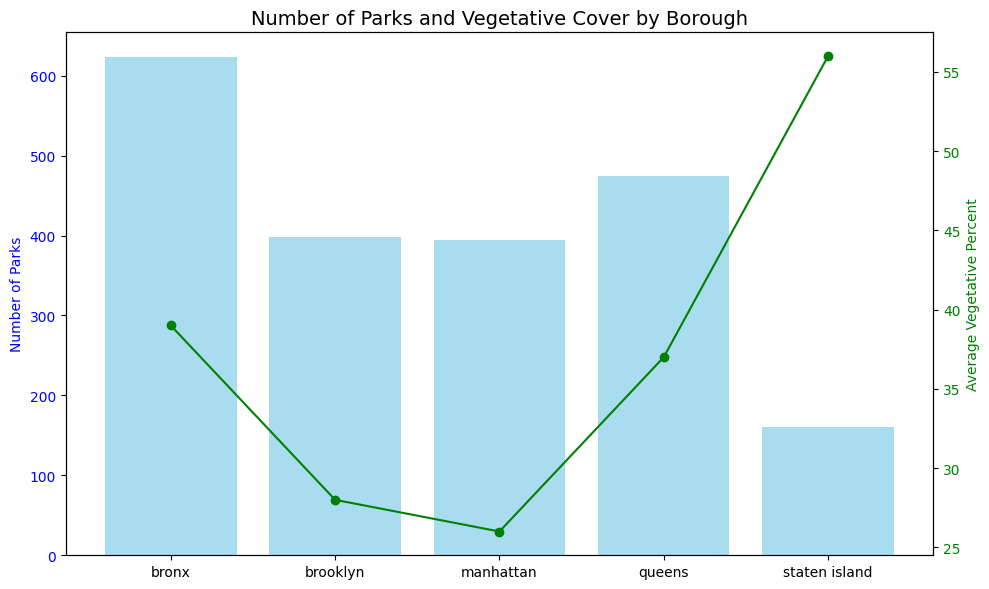

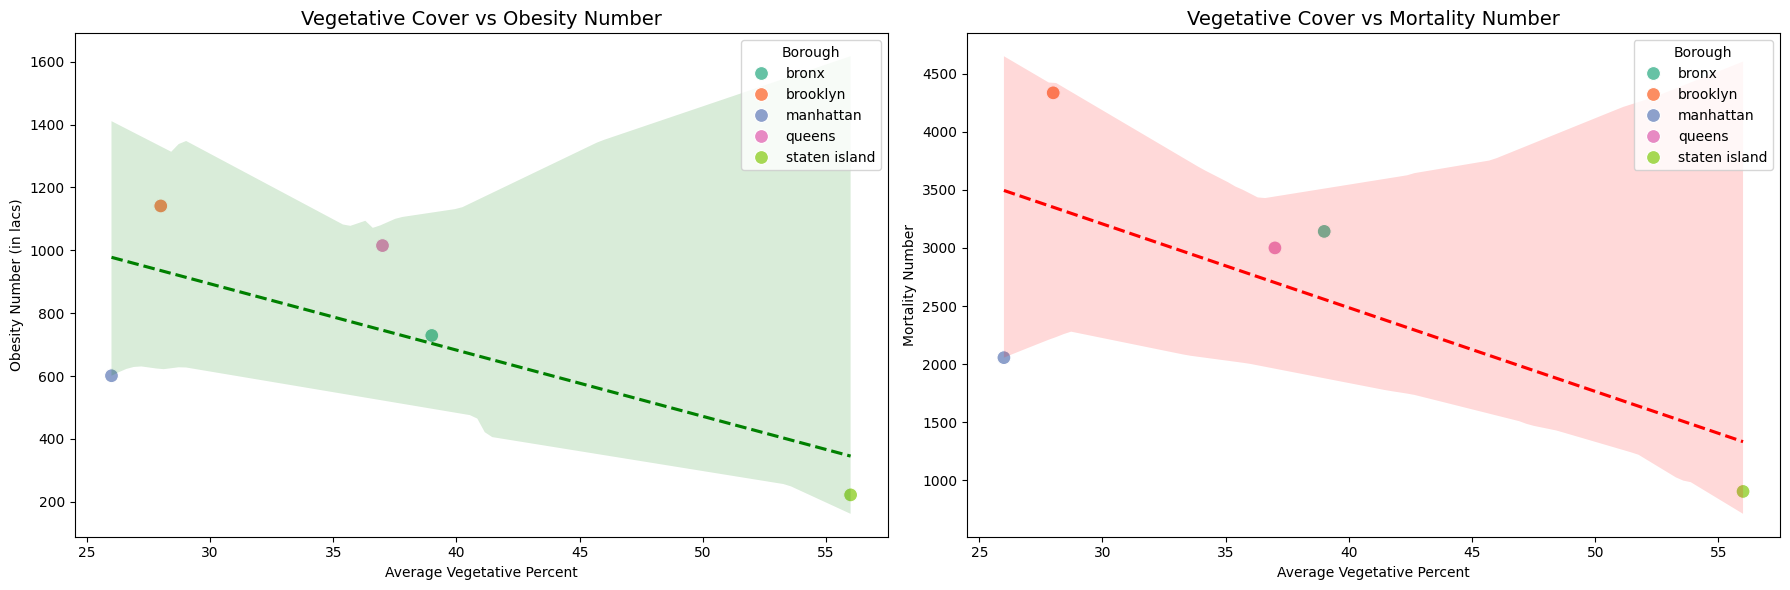

In [ ]:
# RUCHIR
# Loading the dataset
parks_data = pd.read_csv('Parks.csv')

# Defining the columns to keep
columns_to_keep = [
    'GlobalID','ACRES', 'ADDRESS', 'BOROUGH',
    'TYPECATEGORY', 'SUBCATEGORY', 'ZIPCODE', 'WATERFRONT'
]

# Filtering the dataset to keep only the required columns
parks_data_cleaned = parks_data[columns_to_keep]

# Mapping initials to full borough names
borough_mapping = {
    'B': 'Bronx',
    'M': 'Manhattan',
    'Q': 'Queens',
    'R': 'Staten Island',
    'X': 'Brooklyn'
}

# Replacing initials with full names, keeping 'Unknown' for unrecognized values
parks_data_cleaned['BOROUGH'] = parks_data_cleaned['BOROUGH'].map(borough_mapping).fillna('Unknown')

# Loading the obesity, mortality, transportation, and vegetative datasets
obesity_data = pd.read_csv('Obesity.csv')
mortality_data = pd.read_csv('Premature mortality.csv')
transportation_data = pd.read_csv('NYC EH Data Portal - Commuting modes (filtered).csv')
vegetative_data = pd.read_csv('NYC EH Data Portal - Vegetative cover (filtered).csv')

# Ensuring consistent column names and formats
parks_data_cleaned['BOROUGH'] = parks_data_cleaned['BOROUGH'].str.lower()
obesity_data['Geography'] = obesity_data['Geography'].str.lower()
mortality_data['Geography'] = mortality_data['Geography'].str.lower()
transportation_data['Geography'] = transportation_data['Geography'].str.lower()
vegetative_data['Geography'] = vegetative_data['Geography'].str.lower()

# Creating a mapping dictionary for boroughs
borough_mapping = {
    'manhattan': 'manhattan',
    'brooklyn': 'brooklyn',
    'bronx': 'bronx',
    'queens': 'queens',
    'staten island': 'staten island'
}

# Mapping BOROUGH to Geography for the parks dataset
parks_data_cleaned['Geography'] = parks_data_cleaned['BOROUGH'].map(borough_mapping)

# Renaming the 'Percent' column in vegetative data to avoid conflicts
vegetative_data.rename(columns={'Percent': 'Vegetative Percent'}, inplace=True)

# Merging datasets on the 'Geography' column
merged_data = parks_data_cleaned.merge(obesity_data, on='Geography', how='left')
merged_data = merged_data.merge(mortality_data, on='Geography', how='left')
merged_data = merged_data.merge(transportation_data, on='Geography', how='left')
merged_data = merged_data.merge(vegetative_data[['Geography', 'Vegetative Percent']], on='Geography', how='left')

# Columns to include and rename
columns_to_include = {
    'GlobalID': 'GlobalID',
    'ACRES': 'ACRES',
    'ADDRESS': 'ADDRESS',
    'TYPECATEGORY': 'TYPECATEGORY',
    'SUBCATEGORY': 'SUBCATEGORY',
    'ZIPCODE': 'ZIPCODE',
    'WATERFRONT': 'WATERFRONT',
    'Geography': 'Borough',
    'Number_x': 'Obesity Number',
    'Number_y': 'Mortality Number',
    'Bicycle (number)': 'Bicycle (number)',
    'Car, truck, or van (number)': 'Car, truck, or van (number)',
    'Public transportation (number)': 'Public transportation (number)',
    'Walked (number)': 'Walked (number)',
    'Vegetative Percent': 'Vegetative Percent'
}

# Filter and rename the dataset
data = merged_data[list(columns_to_include.keys())].rename(columns=columns_to_include)

# Cleaning and converting relevant columns to numeric
data['Obesity Number'] = data['Obesity Number'].astype(str).str.replace(',', '').astype(float) / 1000
data['Walked (number)'] = data['Walked (number)'].astype(str).str.replace(',', '').astype(float) / 1000
data['ACRES'] = data['ACRES'].astype(str).str.replace(',', '').astype(float)

# Count the number of parks by borough
parks_per_borough = data['Borough'].value_counts()

# Sum obesity and walking numbers by borough
summary_data = data.groupby('Borough')[['Obesity Number', 'Walked (number)']].sum().reset_index()

# Cleaning and converting necessary columns to numeric
data['Obesity Number'] = pd.to_numeric(
    data['Obesity Number'].astype(str).str.replace(',', '', regex=True), errors='coerce'
)
data['Vegetative Percent'] = pd.to_numeric(data['Vegetative Percent'], errors='coerce')

# Aggregating data by borough
summary = data.groupby('Borough').agg(
    total_parks=('GlobalID', 'count'),  # Total number of parks
    avg_vegetative_percent=('Vegetative Percent', 'mean'),  # Average vegetative cover
).reset_index()

# Visualization: Bar Chart for Number of Parks and Vegetative Cover
fig, ax1 = plt.subplots(figsize=(10, 6))

# Bar chart: Number of parks
ax1.bar(summary['Borough'], summary['total_parks'], color='skyblue', alpha=0.7, label='Number of Parks')
ax1.set_ylabel('Number of Parks', color='blue')
ax1.tick_params(axis='y', labelcolor='blue')

# Line plot: Vegetative percent
ax2 = ax1.twinx()
ax2.plot(
    summary['Borough'],
    summary['avg_vegetative_percent'],
    color='green',
    marker='o',
    label='Average Vegetative Cover (%)'
)
ax2.set_ylabel('Average Vegetative Percent', color='green')
ax2.tick_params(axis='y', labelcolor='green')

# Add title and legends
plt.title('Number of Parks and Vegetative Cover by Borough', fontsize=14)
fig.tight_layout()
plt.show()

# Cleaning and converting necessary columns to numeric
data['Mortality Number'] = pd.to_numeric(
    data['Mortality Number'].astype(str).str.replace(',', '', regex=True), errors='coerce'
)

# Selecting the first valid value for each borough
data = data.drop_duplicates(subset=['Borough'])

# Aggregating data by borough
summary = data.groupby('Borough').agg(
    avg_vegetative_percent=('Vegetative Percent', 'mean'),  # Average vegetative cover
    obesity_number=('Obesity Number', 'first'),  # First valid obesity number per borough
    mortality_number=('Mortality Number', 'first')  # First valid mortality number per borough
).reset_index()

# Visualization: Side-by-Side Scatter Plots
fig, axes = plt.subplots(1, 2, figsize=(18, 6), sharex=True)

# Scatter Plot: Vegetative Cover vs Obesity Number
sns.scatterplot(
    data=summary,
    x='avg_vegetative_percent',
    y='obesity_number',
    hue='Borough',
    palette='Set2',
    s=100,
    ax=axes[0]
)
sns.regplot(
    data=summary,
    x='avg_vegetative_percent',
    y='obesity_number',
    scatter=False,
    color='green',
    line_kws={'linestyle': '--'},
    ax=axes[0]
)
axes[0].set_title('Vegetative Cover vs Obesity Number', fontsize=14)
axes[0].set_xlabel('Average Vegetative Percent')
axes[0].set_ylabel('Obesity Number (in lacs)')
axes[0].legend(title='Borough', fontsize=10)

# Scatter Plot: Vegetative Cover vs Mortality Number
sns.scatterplot(
    data=summary,
    x='avg_vegetative_percent',
    y='mortality_number',
    hue='Borough',
    palette='Set2',
    s=100,
    ax=axes[1]
)
sns.regplot(
    data=summary,
    x='avg_vegetative_percent',
    y='mortality_number',
    scatter=False,
    color='red',
    line_kws={'linestyle': '--'},
    ax=axes[1]
)
axes[1].set_title('Vegetative Cover vs Mortality Number', fontsize=14)
axes[1].set_xlabel('Average Vegetative Percent')
axes[1].set_ylabel('Mortality Number')
axes[1].legend(title='Borough', fontsize=10)

# Adjust layout
plt.tight_layout()
plt.show()

### **Transportation and Public Health**

*   The datasets were cleaned by converting numeric columns to appropriate data types, standardizing column names for consistency, and handling non-numeric values. Relevant columns were filtered, and datasets were merged based on a common "geography" column to enable comprehensive analysis.

*   A bar chart was created to visualize the usage of various transportation modes across boroughs.

*   Created a correlation matrix and visualized it as a heatmap to identify relationships between commuting modes, obesity, and mortality.

*   A scatter matrix was used to highlight relationships between commuting habits, obesity, and mortality rates across boroughs.

*   These insights can guide urban planning efforts to improve public health by promoting active commuting modes.



<ipython-input-6-eaf93acfe255>:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_data[col] = filtered_data[col].replace(',', '', regex=True).astype(int)
<ipython-input-6-eaf93acfe255>:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_data[col] = filtered_data[col].replace(',', '', regex=True).astype(int)
<ipython-input-6-eaf93acfe255>:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See 

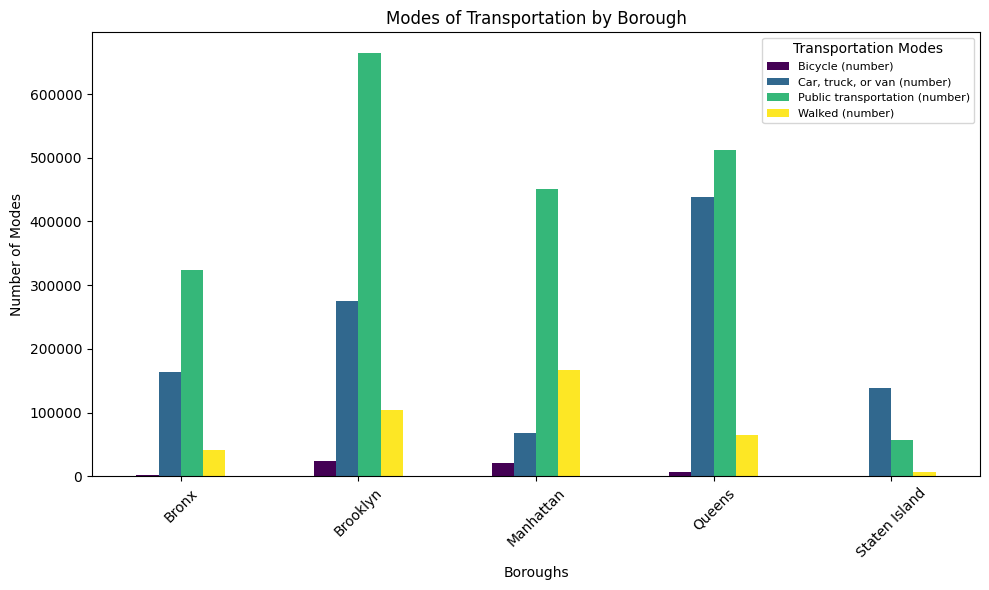

Converted column bicycle (percent) to float.
Converted column car, truck, or van (percent) to float.
Converted column public transportation (percent) to float.
Converted column walked (percent) to float.
Converted column obesity_percent to float.
Converted column mortality_percent to float.


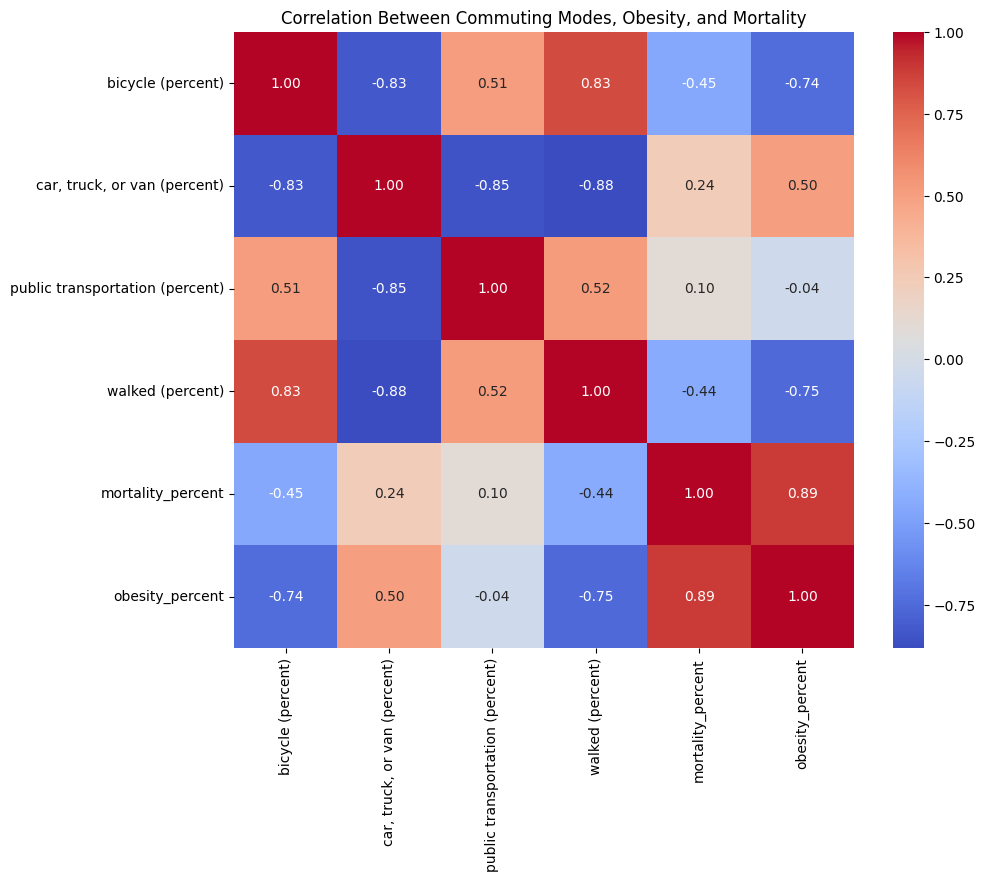

In [ ]:
# SURIYA
# File paths
commuting_modes_file = "NYC EH Data Portal - Commuting modes (filtered).csv"
obesity_file = "Obesity.csv"
mortality_file = "Premature mortality.csv"

# Load datasets
transportation_data = pd.read_csv(commuting_modes_file)
obesity_data = pd.read_csv(obesity_file)
mortality_data = pd.read_csv(mortality_file)

# selecting only the necessary columns
filtered_data = transportation_data[['Geography', 'Bicycle (number)', 'Car, truck, or van (number)',
                      'Public transportation (number)', 'Walked (number)']]

# converting numeric columns to integers
numeric_columns = ['Bicycle (number)', 'Car, truck, or van (number)',
                   'Public transportation (number)', 'Walked (number)']
for col in numeric_columns:
    filtered_data[col] = filtered_data[col].replace(',', '', regex=True).astype(int)

# grouping by Geography and summing the modes
grouped_data = filtered_data.groupby('Geography')[numeric_columns].sum().reset_index()

# setting up the bar plot
grouped_data.set_index('Geography', inplace=True)
grouped_data.plot(kind='bar', figsize=(10, 6), colormap='viridis')

# customizing the plot
plt.title('Modes of Transportation by Borough', fontsize=12)
plt.xlabel('Boroughs', fontsize=10)
plt.ylabel('Number of Modes', fontsize=10)
plt.xticks(rotation=45)
plt.legend(title='Transportation Modes', fontsize=8)
plt.tight_layout()

# displaying the plot
plt.show()

# Checking for commonality in "geography" column naming and merging datasets
obesity_data = obesity_data.rename(columns={"Percent": "obesity_percent"})
mortality_data = mortality_data.rename(columns={"Age-adjusted rate per 100,000": "mortality_percent"})

obesity_data['obesity_percent'] = obesity_data['obesity_percent'].str.extract(r'^(\d+\.?\d*)').astype(float)

# Standardizing column names to lowercase for consistency
transportation_data.columns = transportation_data.columns.str.lower()
obesity_data.columns = obesity_data.columns.str.lower()
mortality_data.columns = mortality_data.columns.str.lower()

# Performing inner join on "geography" for all datasets
merged_data = pd.merge(transportation_data, obesity_data, on="geography", how="inner")
merged_data = pd.merge(merged_data, mortality_data, on="geography", how="inner")

# Replace with the actual DataFrame name
# Assuming the DataFrame is named `data`
columns_to_convert = [
    "bicycle (percent)",
    "car, truck, or van (percent)",
    "public transportation (percent)",
    "walked (percent)",
    "obesity_percent",  # Adjust if `mortality_rate` is used
    "mortality_percent"
]

# Convert specified columns to float, handling errors
for column in columns_to_convert:
    try:
        # If any non-numeric strings exist, they will be converted to NaN
        merged_data[column] = pd.to_numeric(merged_data[column], errors="coerce")
        print(f"Converted column {column} to float.")
    except KeyError:
        print(f"Column {column} not found in the DataFrame.")

# Select columns for commuting modes, obesity, and mortality
columns_to_keep = [
    "bicycle (percent)",
    "car, truck, or van (percent)",
    "public transportation (percent)",
    "walked (percent)",
    "mortality_percent",  # Replace with the actual column name for obesity rate
    "obesity_percent"  # Mortality rate column
]

# Filter merged data
analysis_data = merged_data[columns_to_keep]

# Ensure numeric columns are included for correlation analysis
numeric_columns = analysis_data.select_dtypes(include=['float64', 'int64']).columns

# Compute correlation matrix for numeric columns
correlation_matrix = analysis_data[numeric_columns].corr()

# Plot the correlation matrix as a heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap="coolwarm", cbar=True)
plt.title("Correlation Between Commuting Modes, Obesity, and Mortality")
plt.show()

fig = px.scatter_matrix(
    merged_data,
    dimensions=[
        "car, truck, or van (percent)",
        "public transportation (percent)",
        "obesity_percent",
        "mortality_percent"
    ],
    color="geography",
    title="Scatter Matrix of Commuting Methods, Obesity, and Mortality Rates",
    labels={
        "car, truck, or van (percent)": "Car/Truck/Van %",
        "public transportation (percent)": "Public Transport %",
        "obesity_percent": "Obesity Rate",
        "mortality_percent": "Mortality Rate"
    }
)

# Update the layout to prevent overlapping
fig.update_layout(
    height=900,  # Increase height
    width=900,   # Increase width
    title_font=dict(size=16),  # Adjust title font size
    font=dict(size=12),        # Adjust label font size
    margin=dict(l=50, r=50, t=50, b=50)  # Adjust margins
)

# Adjust the orientation of the tick labels on both axes
fig.update_xaxes(tickangle=45)  # Rotate x-axis labels
fig.update_yaxes(automargin=True)  # Add margin for y-axis
fig.show()


### **Impact of Active Lifestyle on Health and Mortality**

* Focused on the relationship between physical activity levels and premature mortality.

* Utilized datasets on physical activity participation and mortality rates to perform statistical tests.

* Developed dynamic visualizations, including regression plots, to show how increased physical activity correlates with reduced mortality rates.

* Found that boroughs with higher participation in active lifestyles (e.g., Manhattan) report significantly lower mortality rates than less active boroughs.

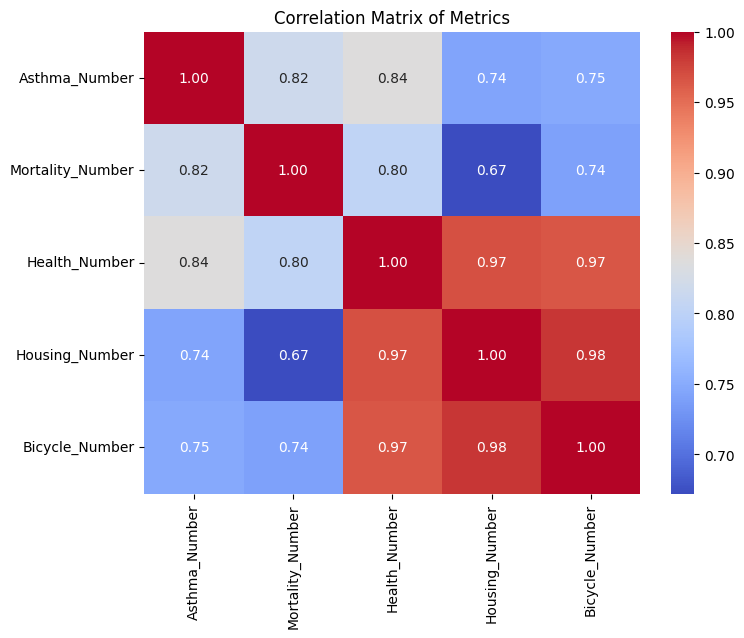

                            OLS Regression Results                            
Dep. Variable:       Mortality_Number   R-squared:                       0.813
Model:                            OLS   Adj. R-squared:                  0.808
Method:                 Least Squares   F-statistic:                     189.5
Date:                Mon, 09 Dec 2024   Prob (F-statistic):           1.85e-47
Time:                        23:31:56   Log-Likelihood:                -1029.7
No. Observations:                 135   AIC:                             2067.
Df Residuals:                     131   BIC:                             2079.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
const            662.6989    116.718      5.

In [ ]:
# VAIBHAVI
# Load datasets (replace with actual file paths or DataFrame names)
asthma_df = pd.read_csv('asthma.csv')
mortality_df = pd.read_csv('Premature mortality.csv')
housing_df = pd.read_csv('housing.csv')
health_df = pd.read_csv('health.csv')
bicycle_df = pd.read_csv('bicycle.csv')

# Convert 'Number' columns to numeric after removing commas and handling '*'
for df in [ asthma_df, mortality_df, health_df, housing_df, bicycle_df]:
    df['Number'] = pd.to_numeric(df['Number'].str.replace(',', '').str.replace('*', ''), errors='coerce')

# Rename the columns for better understanding
asthma_df = asthma_df.rename(columns= {"Number": "Asthma_Number"})
mortality_df = mortality_df.rename(columns = {"Number": "Mortality_Number"})
health_df = health_df.rename(columns = {"Number": "Health_Number"})
housing_df = housing_df.rename(columns = {"Number": "Housing_Number"})
bicycle_df = bicycle_df.rename(columns = {"Number": "Bicycle_Number"})

asthma_df['Asthma_Number'] = asthma_df['Asthma_Number']
mortality_df['Mortality_Number'] = mortality_df['Mortality_Number']
health_df['Health_Number'] = health_df['Health_Number']
housing_df['Housing_Number'] = housing_df['Housing_Number']
bicycle_df['Bicycle_Number'] = bicycle_df['Bicycle_Number']

# Merge datasets on 'Geography'
df = (
      asthma_df[['Geography', 'Asthma_Number']]
    .merge(mortality_df[['Geography', 'Mortality_Number']], on='Geography')
    .merge(health_df[['Geography', 'Health_Number']], on='Geography')
    .merge(housing_df[['Geography', 'Housing_Number']], on='Geography')
    .merge(bicycle_df[['Geography', 'Bicycle_Number']], on='Geography')
)
# Compute correlations
correlation_matrix = df.drop('Geography', axis=1).corr()

# Visualization of correlations
plt.figure(figsize=(8, 6))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Matrix of Metrics')
plt.show()

# Regression Analysis for Mortality vs Asthma + Housing + Bicycle
X = df[["Asthma_Number", "Housing_Number", "Bicycle_Number"]]
y = df["Mortality_Number"]

# Fit model
X = sm.add_constant(X)  # Adds constant term for intercept
model = sm.OLS(y, X).fit()
print(model.summary())

# Create a scatter plot with regression line
fig = px.scatter(
    df,
    x='Bicycle_Number',
    y='Mortality_Number',
    color='Health_Number',  # Color points by health number
    size='Housing_Number',  # Bubble size by housing number
    title="Bicycle Numbers vs Mortality Numbers with Health and Housing Information",
    labels={'Bicycle_Number': 'Bicycle Numbers', 'Mortality_Number': 'Mortality Numbers'},
    trendline="ols"  # Adds a regression line
)

# Show the plot
fig.show()

### **Impact of Housing and Neighborhood on Public Health**

* Calculated Housing Density (Population per Housing Unit) for each borough to assess overcrowding.

* Integrated data on Poverty Percentage, Violence Rate, and Mortality Rate to explore neighborhood-level health impacts.

* Conducted correlation analysis to identify key relationships among housing and health factors.

* Created visualizations, including:
        * Heatmap: Highlighted strong correlations (e.g., Poverty and Mortality Rates).
        * Scatter Plot: Showed that higher Housing Density is associated with increased Mortality Rates.
        * Pairplot: Explored interactions among Poverty, Violence, and Mortality.

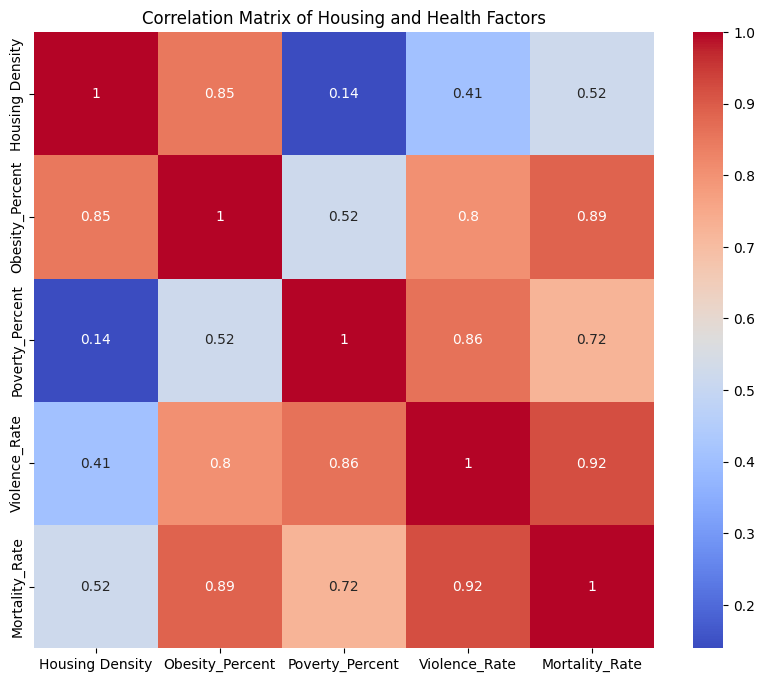

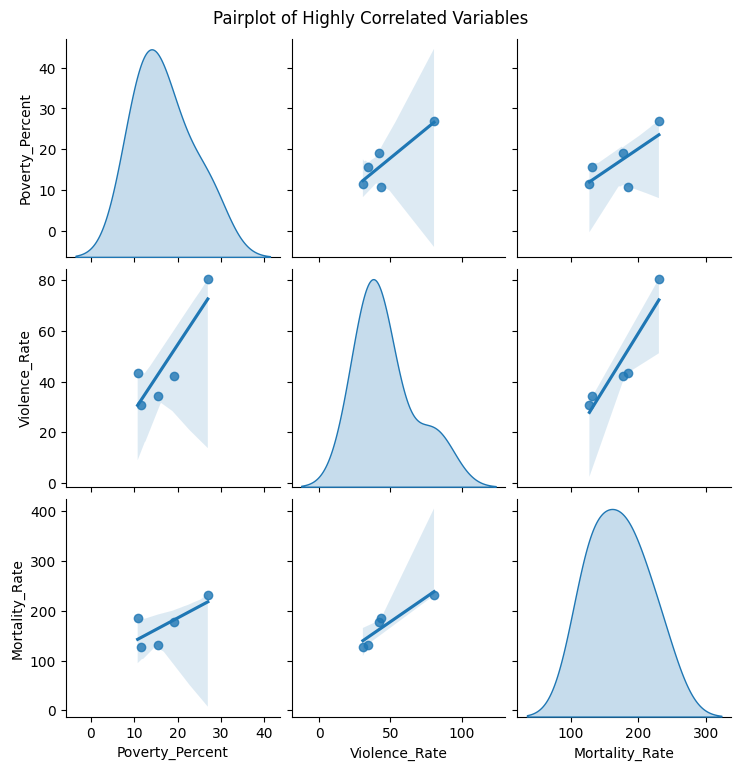

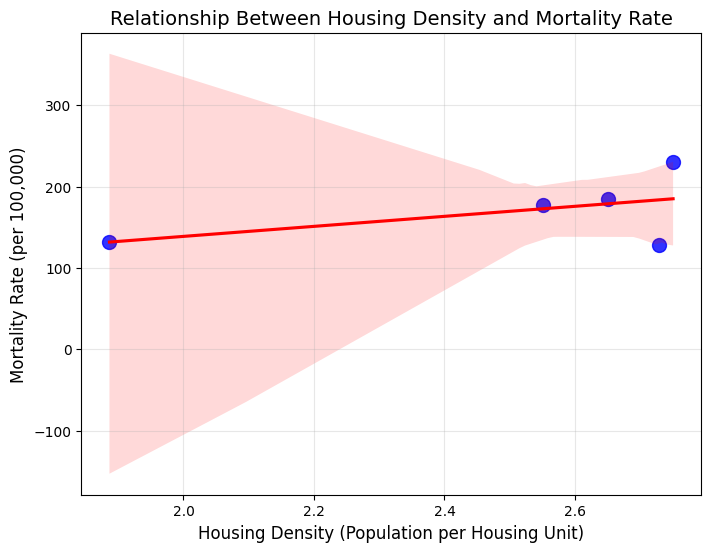

In [ ]:
# ARSH
# Load datasets
obesity_data = pd.read_csv('Obesity.csv')
poverty_data = pd.read_csv('Neighborhood poverty.csv')
violence_data = pd.read_csv('Violence.csv')
mortality_data = pd.read_csv('Premature mortality.csv')

# Fetch geographic data
geomap = "https://data.cityofnewyork.us/resource/7t3b-ywvw.json"
response = requests.get(geomap)
geomap_data = response.json()

# Convert geomap data to GeoDataFrame
geo_data = pd.DataFrame(geomap_data)
if 'the_geom' in geo_data.columns:
    geo_data['geometry'] = geo_data['the_geom'].apply(lambda x: shape(x) if x else None)
geo_gdf = gpd.GeoDataFrame(geo_data, geometry='geometry', crs="EPSG:4326")

# Preprocess datasets
# Calculate Housing Density
# Creating a DataFrame to calculate Housing Density from housing data
house_data = {
    "Geography": ["Bronx", "Brooklyn", "Manhattan", "Queens", "Staten Island"],
    "Population": [1436785, 2606852, 1634989, 2310011, 473324],
    "Housing Units": [522401, 1021747, 866644, 846689, 178603]
}

housing = pd.DataFrame(house_data)
# Calculate Housing Density
housing["Housing Density"] = housing["Population"] / housing["Housing Units"]

# Renaming columns in each dataset to make them unique
obesity_data = obesity_data.rename(columns = {"Number": "Obesity_Number", "Percent": "Obesity_Percent"})
poverty_data = poverty_data.rename(columns={"Number": "Poverty_Number", "Percent": "Poverty_Percent"})
violence_data = violence_data.rename(columns={"Number": "Violence_Number", "Age-adjusted rate per 100,000": "Violence_Rate"})
mortality_data = mortality_data.rename(columns={"Number": "Mortality_Number", "Age-adjusted rate per 100,000": "Mortality_Rate"})

# Dropping conflicting columns from datasets
obesity_data = obesity_data.drop(columns=['TimePeriod', 'GeoTypeDesc', 'GeoID', 'GeoRank'], errors='ignore')
poverty_data = poverty_data.drop(columns=['TimePeriod', 'GeoTypeDesc', 'GeoID', 'GeoRank'], errors='ignore')
violence_data = violence_data.drop(columns=['TimePeriod', 'GeoTypeDesc', 'GeoID', 'GeoRank'], errors='ignore')
mortality_data = mortality_data.drop(columns=['TimePeriod', 'GeoTypeDesc', 'GeoID', 'GeoRank'], errors='ignore')

# List of columns to clean in each dataset
columns_to_clean_obesity = ['Obesity_Number']
columns_to_clean_violence = ['Violence_Number']
columns_to_clean_mortality = ['Mortality_Number']
columns_to_clean_poverty = ['Poverty_Number']

# Remove commas and convert to numeric for overcrowding data
for column in columns_to_clean_obesity:
    obesity_data[column] = obesity_data[column].astype(str).str.replace(',', '').astype(float)

# Remove commas and convert to numeric for overcrowding data
for column in columns_to_clean_violence:
    violence_data[column] = violence_data[column].astype(str).str.replace(',', '').astype(float)

# Remove commas and convert to numeric for overcrowding data
for column in columns_to_clean_mortality:
    mortality_data[column] = mortality_data[column].astype(str).str.replace(',', '').astype(float)

# Remove commas and convert to numeric for neighborhood poverty data
for column in columns_to_clean_poverty:
    poverty_data[column] = poverty_data[column].astype(str).str.replace(',', '').astype(float)

# Convert the 'Percent' column values from string to float in Obesity dataset
# Extract the first part of the value before the space
obesity_data['Obesity_Percent'] = obesity_data['Obesity_Percent'].str.extract(r'^(\d+\.?\d*)').astype(float)

# Merge datasets
datasets = [obesity_data, poverty_data, violence_data, mortality_data]
for dataset in datasets:
    housing = housing.merge(dataset, on='Geography', how='left')

# Merge with geospatial data
merged_gdf = geo_gdf.merge(housing, left_on='boro_name', right_on='Geography', how='left')

# Including required columns for correlation analysis
columns_to_include = [
    'Housing Density', 'Obesity_Percent',
    'Poverty_Percent',
    'Violence_Rate', 'Mortality_Rate',
]

# Selected only the required columns from the housing data
numeric_data = housing[columns_to_include]

# Correlation Analysis
plt.figure(figsize=(10, 8))
sns.heatmap(numeric_data.corr(), annot=True, cmap='coolwarm')
plt.title('Correlation Matrix of Housing and Health Factors')
plt.show()

# Pairplot for correlated variables
correlated_vars = ['Poverty_Percent', 'Violence_Rate', 'Mortality_Rate']
sns.pairplot(merged_gdf[correlated_vars], kind='reg', diag_kind='kde')
plt.suptitle('Pairplot of Highly Correlated Variables', y=1.02)
plt.show()

# Scatter plot with regression line
plt.figure(figsize=(8, 6))
sns.regplot(
    x='Housing Density',
    y='Mortality_Rate',
    data=merged_gdf,
    scatter_kws={'color': 'blue', 's': 100},  # Style for scatter points
    line_kws={'color': 'red'},  # Style for regression line
)
plt.title('Relationship Between Housing Density and Mortality Rate', fontsize=14)
plt.xlabel('Housing Density (Population per Housing Unit)', fontsize=12)
plt.ylabel('Mortality Rate (per 100,000)', fontsize=12)
plt.grid(alpha=0.3)
plt.show()